In [84]:
import numpy as np
import matplotlib.pyplot as plt
import bemcs

### Define functions for stress kernel & boundary conditions -> 3qn coefficients calculations

In [85]:

def get_quadratic_stresskernel(x_obs,y_obs,elements,mu,nu):
    """Each stress kernel is a matrix of dimensions 
        Kxx = Nobs x 3xNpatches 
        Kyy = Nobs x 3xNpatches
        Kxy = Nobs x 3xNpatches"""
    Kxx = np.zeros((len(x_obs),3*len(elements)))
    Kyy = np.zeros((len(x_obs),3*len(elements)))
    Kxy = np.zeros((len(x_obs),3*len(elements)))

    tensile_slip = [0.0, 0.0, 0.0]

    for i in range(len(elements)):    
        # go through each of the 3 components for a given patch
        # component 1
        strike_slip = [1.0, 0.0, 0.0]        
        # Calculate displacements and stresses for current element
        displacement_eval,stress_eval = bemcs.displacements_stresses_quadratic_no_rotation(
            x_obs,y_obs,elements[i]["half_length"],mu,nu,strike_slip,tensile_slip,
            elements[i]["x_center"],elements[i]["y_center"])
        index = 3*i
        Kxx[:,index] = stress_eval[0,:]
        Kyy[:,index] = stress_eval[1,:]
        Kxy[:,index] = stress_eval[2,:]

        # component 2
        strike_slip = [0.0, 1.0, 0.0]        
        # Calculate displacements and stresses for current element
        displacement_eval,stress_eval = bemcs.displacements_stresses_quadratic_no_rotation(
            x_obs,y_obs,elements[i]["half_length"],mu,nu,strike_slip,tensile_slip,
            elements[i]["x_center"],elements[i]["y_center"])
        index = 3*i + 1
        Kxx[:,index] = stress_eval[0,:]
        Kyy[:,index] = stress_eval[1,:]
        Kxy[:,index] = stress_eval[2,:]

        # component 3
        strike_slip = [0.0, 0.0, 1.0]        
        # Calculate displacements and stresses for current element
        displacement_eval,stress_eval = bemcs.displacements_stresses_quadratic_no_rotation(
            x_obs,y_obs,elements[i]["half_length"],mu,nu,strike_slip,tensile_slip,
            elements[i]["x_center"],elements[i]["y_center"])
        index = 3*i + 2
        Kxx[:,index] = stress_eval[0,:]
        Kyy[:,index] = stress_eval[1,:]
        Kxy[:,index] = stress_eval[2,:]

    return Kxx, Kyy, Kxy

def get_designmatrix_3qn(elements):
    """ Compute design matrix for linear system to calculate quadratic coefficients from applied boundary conditions
        Currently only apply slip, slip gradient boundary conditions as well as
        continuity and 1-differentiability of slip at internal overlapping nodes"""
    designmatrix_slip = np.zeros((3*len(elements),3*len(elements)))
    designmatrix_slipgradient = np.zeros((3*len(elements),3*len(elements)))

    for i in range(len(elements)):
        slip_matrix = np.zeros((3,3))
        slipgradient_matrix = np.zeros((3,3))
        
        x_obs = np.array((elements[i]["x1"]-elements[i]["x_center"], 0., elements[i]["x2"]-elements[i]["x_center"]))

        slip_matrix = bemcs.slip_functions(x_obs, elements[i]["half_length"])        
        designmatrix_slip[3*i:3*i+3,3*i:3*i+3] = slip_matrix

        slipgradient_matrix = bemcs.slipgradient_functions(x_obs, elements[i]["half_length"])        
        designmatrix_slipgradient[3*i:3*i+3,3*i:3*i+3] = slipgradient_matrix

    return designmatrix_slip, designmatrix_slipgradient

### Create a planar mesh and visualize nodes and patch centers

The patches can be non-uniform in length as long as they are all co-planar. Dealing with rough faults is the next step.

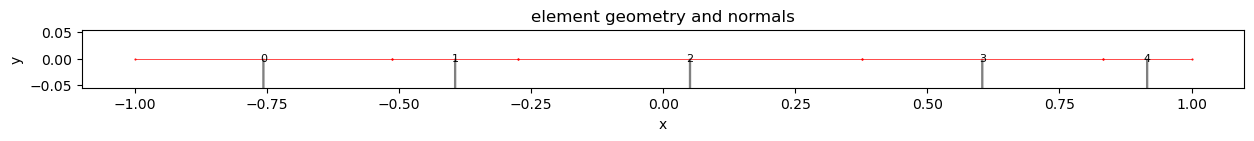

In [86]:
# define a mesh
n_elements = 5
elements = []
element = {}
L = 1
# Elastic parameters
mu_shear = np.array([1])
nu = np.array([0.25])

# for a uniform discretization
# x1, y1, x2, y2 = bemcs.discretized_line(-L, 0, L, 0, n_elements)

# use a non-uniform mesh
# x1 = np.array((-1,-0.5,0.,0.3,0.5,0.9))
# x2 = np.array((-0.5,0.,0.3,0.5,0.9,1.))
sorted_xlocs = np.sort(np.random.uniform(size=n_elements-1,low=-0.99,high=0.99))
x1 = np.concatenate((np.array([-1.]), sorted_xlocs))
x2 = np.concatenate((sorted_xlocs,np.array([1.])))
y1 = np.zeros_like(x1)
y2 = np.zeros_like(x2)

# imposed slip at patch centers (make sure it is the same dimensions as x1)
slip_vector = np.random.uniform(size=n_elements)
# slip_vector = np.array((0.1,1.0,2.1,2.1,0.9,0.01))

for i in range(n_elements):
    element["x1"] = x1[i]
    element["y1"] = y1[i]
    element["x2"] = x2[i]
    element["y2"] = y2[i]
    elements.append(element.copy())
elements = bemcs.standardize_elements(elements)

# plot geometry of mesh
plt.figure(figsize=(15,5))
bemcs.plot_element_geometry(elements)

### Provide coordinates of observation points
Currently we are only looking at points very close to the fault. The reason it's not exactly on the fault is because I am a bit confused about the coincident and far field calculations. The function values in bemcs.py don't look identical, and so I will leave that for you (Brendan) to explain/fix when you are back.

In [87]:
# observation coordinates for displacement,slip and stress
n_obs = 400
x_obs = np.linspace(-1.5, 1.5, n_obs)
y_obs = 1e-9 * np.ones_like(x_obs)

# design matrices for slip and slip gradients at each 3qn
matrix_slip, matrix_slipgradient = get_designmatrix_3qn(elements)
matrix_system = np.zeros((len(elements)*3,len(elements)*3))

""" boundary conditions to solve for 3xNpatch unknown 3qn coefficients are as follows:
    (1) Npatch slip values at patch centers
    (2) Npatch-1 internal slip continuity at overlapping nodes
    (3) Npatch-1 internal slip gradient continuity at overlapping nodes
    (4) 2 slip gradients at the boundaries
"""

# Boundary conditions are ordered as patch1[n1,n2],patch1[n3]=patch2[n1],patch1[n3]grad=patch1[n1]grad,patch2[n2],....,patchN[n2,n3]
BCvector = np.zeros((len(elements)*3,1))
# slip gradients at the boundaries (we set them to 0 in this example)
BCvector[0] = 0
BCvector[-1] = 0

# slip imposed at central nodes of each patch
BCvector[1:-1:3] = slip_vector.reshape(-1,1)

# Linear operator for BCs as a matrix
# boundary nodes
matrix_system[0,:] = matrix_slipgradient[0,:]
matrix_system[-1,:] = matrix_slipgradient[-1,:]
# patch center nodes
matrix_system[1:-1:3,:] = matrix_slip[1:-1:3,:]
# overlapping interior nodes (apply slip continuity and smoothness)
matrix_system[2:-3:3,:] = matrix_slip[2:-3:3,:] - matrix_slip[3:-2:3,:]
matrix_system[3:-2:3,:] = matrix_slipgradient[2:-3:3,:] - matrix_slipgradient[3:-2:3,:]

# compute quadratic node coefficients
quadratic_coefs = np.linalg.inv(matrix_system) @ BCvector
print(quadratic_coefs.T)

[[0.14521644 0.26412403 0.5019392  0.74585812 0.86471928 0.92760601
  0.94427118 0.93746884 0.9050308  0.84986958 0.73738682 0.55313719
  0.3908399  0.32791642 0.29645468]]


### Compute fault slip and stress change as a function of x along the fault from 3qn coefficients

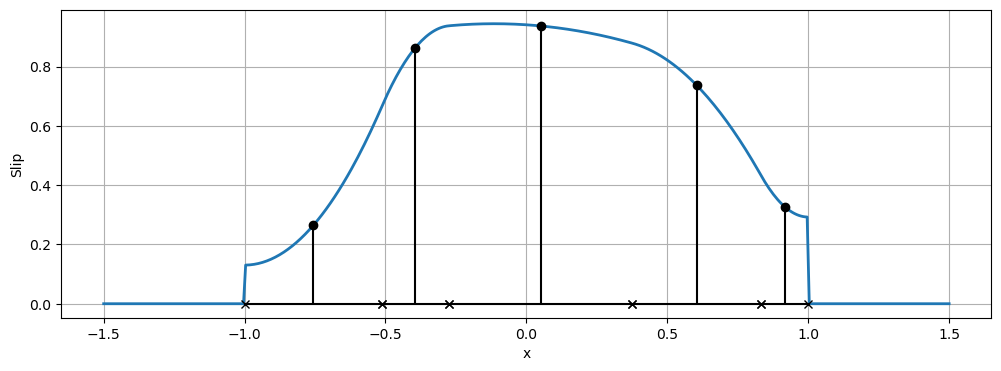

In [88]:
# get slip along the fault from quadratic coefficients
slip_fullfault = np.zeros((n_obs,1))
for i in range(len(elements)):
    index = list(range(3*i, 3*i+3, 1))
    slip_patch,_ = bemcs.get_slip_slipgradient(x_obs-elements[i]["x_center"], elements[i]["half_length"], quadratic_coefs[index])
    # need to set slip from a given patch to 0 outside the domain of that patch
    slip_patch[(x_obs<elements[i]["x1"])|(x_obs>elements[i]["x2"])] = 0

    slip_fullfault += slip_patch # slip on the full fault is a sum of slip from each patch

plt.figure(figsize=(12,4))
plt.plot(x_obs,slip_fullfault,linewidth=2)
for i in range(len(elements)):
    plt.stem(elements[i]["x_center"],slip_vector[i],'k')
    plt.plot(np.array((elements[i]["x1"],elements[i]["x2"])),np.array((0,0)),'kx-')
plt.grid(True)
plt.xlabel("x")
plt.ylabel("Slip")
plt.show(block=False)

For stress calculation, we need a better way to store the kernels. We have 3 components of stress for each slip component (shear/tensile) so that makes the stress kernel a tensor of dimensions: 

- N_locations x 3xN_patches x 3xstress_components x 2xslip_components

Similarly kernels for traction vectors rotated to fault-shear and fault-normal directions will be of dimensions:

- N_locations x 3xN_patches x 2xtraction_components x 2xslip_components

And kernels for displacement vectors will be of dimensions:

- N_locations x 3xN_patches x 2xdisplacement_components x 2xslip_components


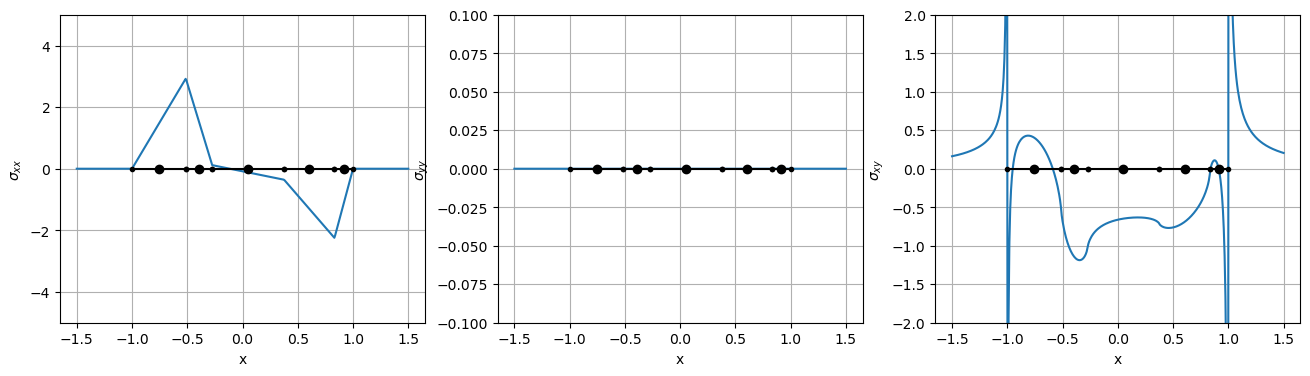

In [92]:
# Stress kernels
Kxx,Kyy,Kxy = get_quadratic_stresskernel(x_obs,y_obs,elements,mu_shear,nu)
Sxx = Kxx@quadratic_coefs
Syy = Kyy@quadratic_coefs
Sxy = Kxy@quadratic_coefs

# Plot stresses
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.plot(x_obs, Sxx)
for i in range(len(elements)):
    plt.plot(elements[i]["x_center"],0,'ko')
    plt.plot(np.array((elements[i]["x1"],elements[i]["x2"])),np.array((0,0)),'k.-')
plt.grid()
plt.xlabel("x")
plt.ylabel("$\sigma_{xx}$")
plt.ylim((-5,5))

plt.subplot(1, 3, 2)
plt.plot(x_obs, Syy)
for i in range(len(elements)):
    plt.plot(elements[i]["x_center"],0,'ko')
    plt.plot(np.array((elements[i]["x1"],elements[i]["x2"])),np.array((0,0)),'k.-')
plt.grid()
plt.xlabel("x")
plt.ylabel("$\sigma_{yy}$")
plt.ylim((-0.1,0.1))

plt.subplot(1, 3, 3)
plt.plot(x_obs, Sxy)
for i in range(len(elements)):
    plt.plot(elements[i]["x_center"],0,'ko')
    plt.plot(np.array((elements[i]["x1"],elements[i]["x2"])),np.array((0,0)),'k.-')
plt.grid()
plt.xlabel("x")
plt.ylabel("$\sigma_{xy}$")
plt.ylim((-2,2))
plt.show()